<a href="https://colab.research.google.com/github/haseebshaik00/Optimizing-Health-Insights/blob/main/optimizing_health_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Health Insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install scikit-learn==1.0.2

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.


## Load datasets

In [2]:
exercise_df = pd.read_csv('./exercise.csv')
calories_df = pd.read_csv('./calories.csv')

## Merge datasets

In [3]:
data = pd.merge(exercise_df, calories_df, on='User_ID')

## Exploratory Data Analysis


In [4]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB
None
            User_ID           Age        Height        Weight      Duration  \
count  1.500000e+04  15000.000000  15000.000000  15000.000000  15000.000000   
mean   1.497736e+07     42.789800    174.465133     74.966867     15.530600   
std    2.872851e+06     16.980264     14.258114     15.035657      8.319203   
min    1.000116e+07     20.000000    123.000000     36.000

## Check for missing values

In [5]:
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


## Data visualization

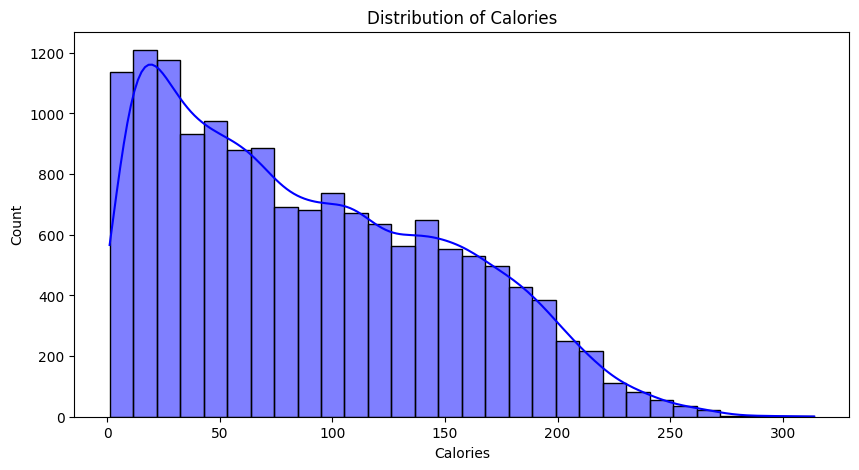

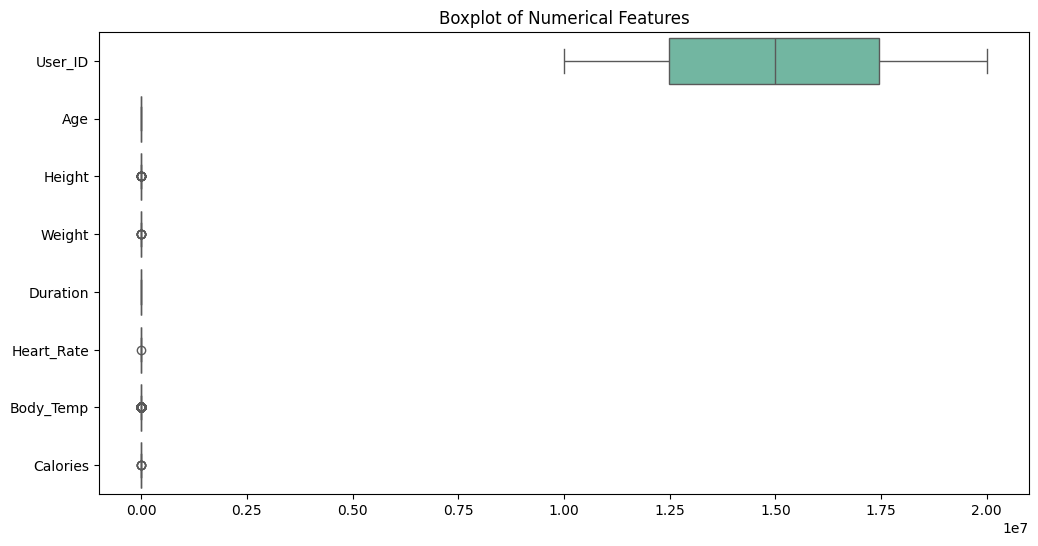

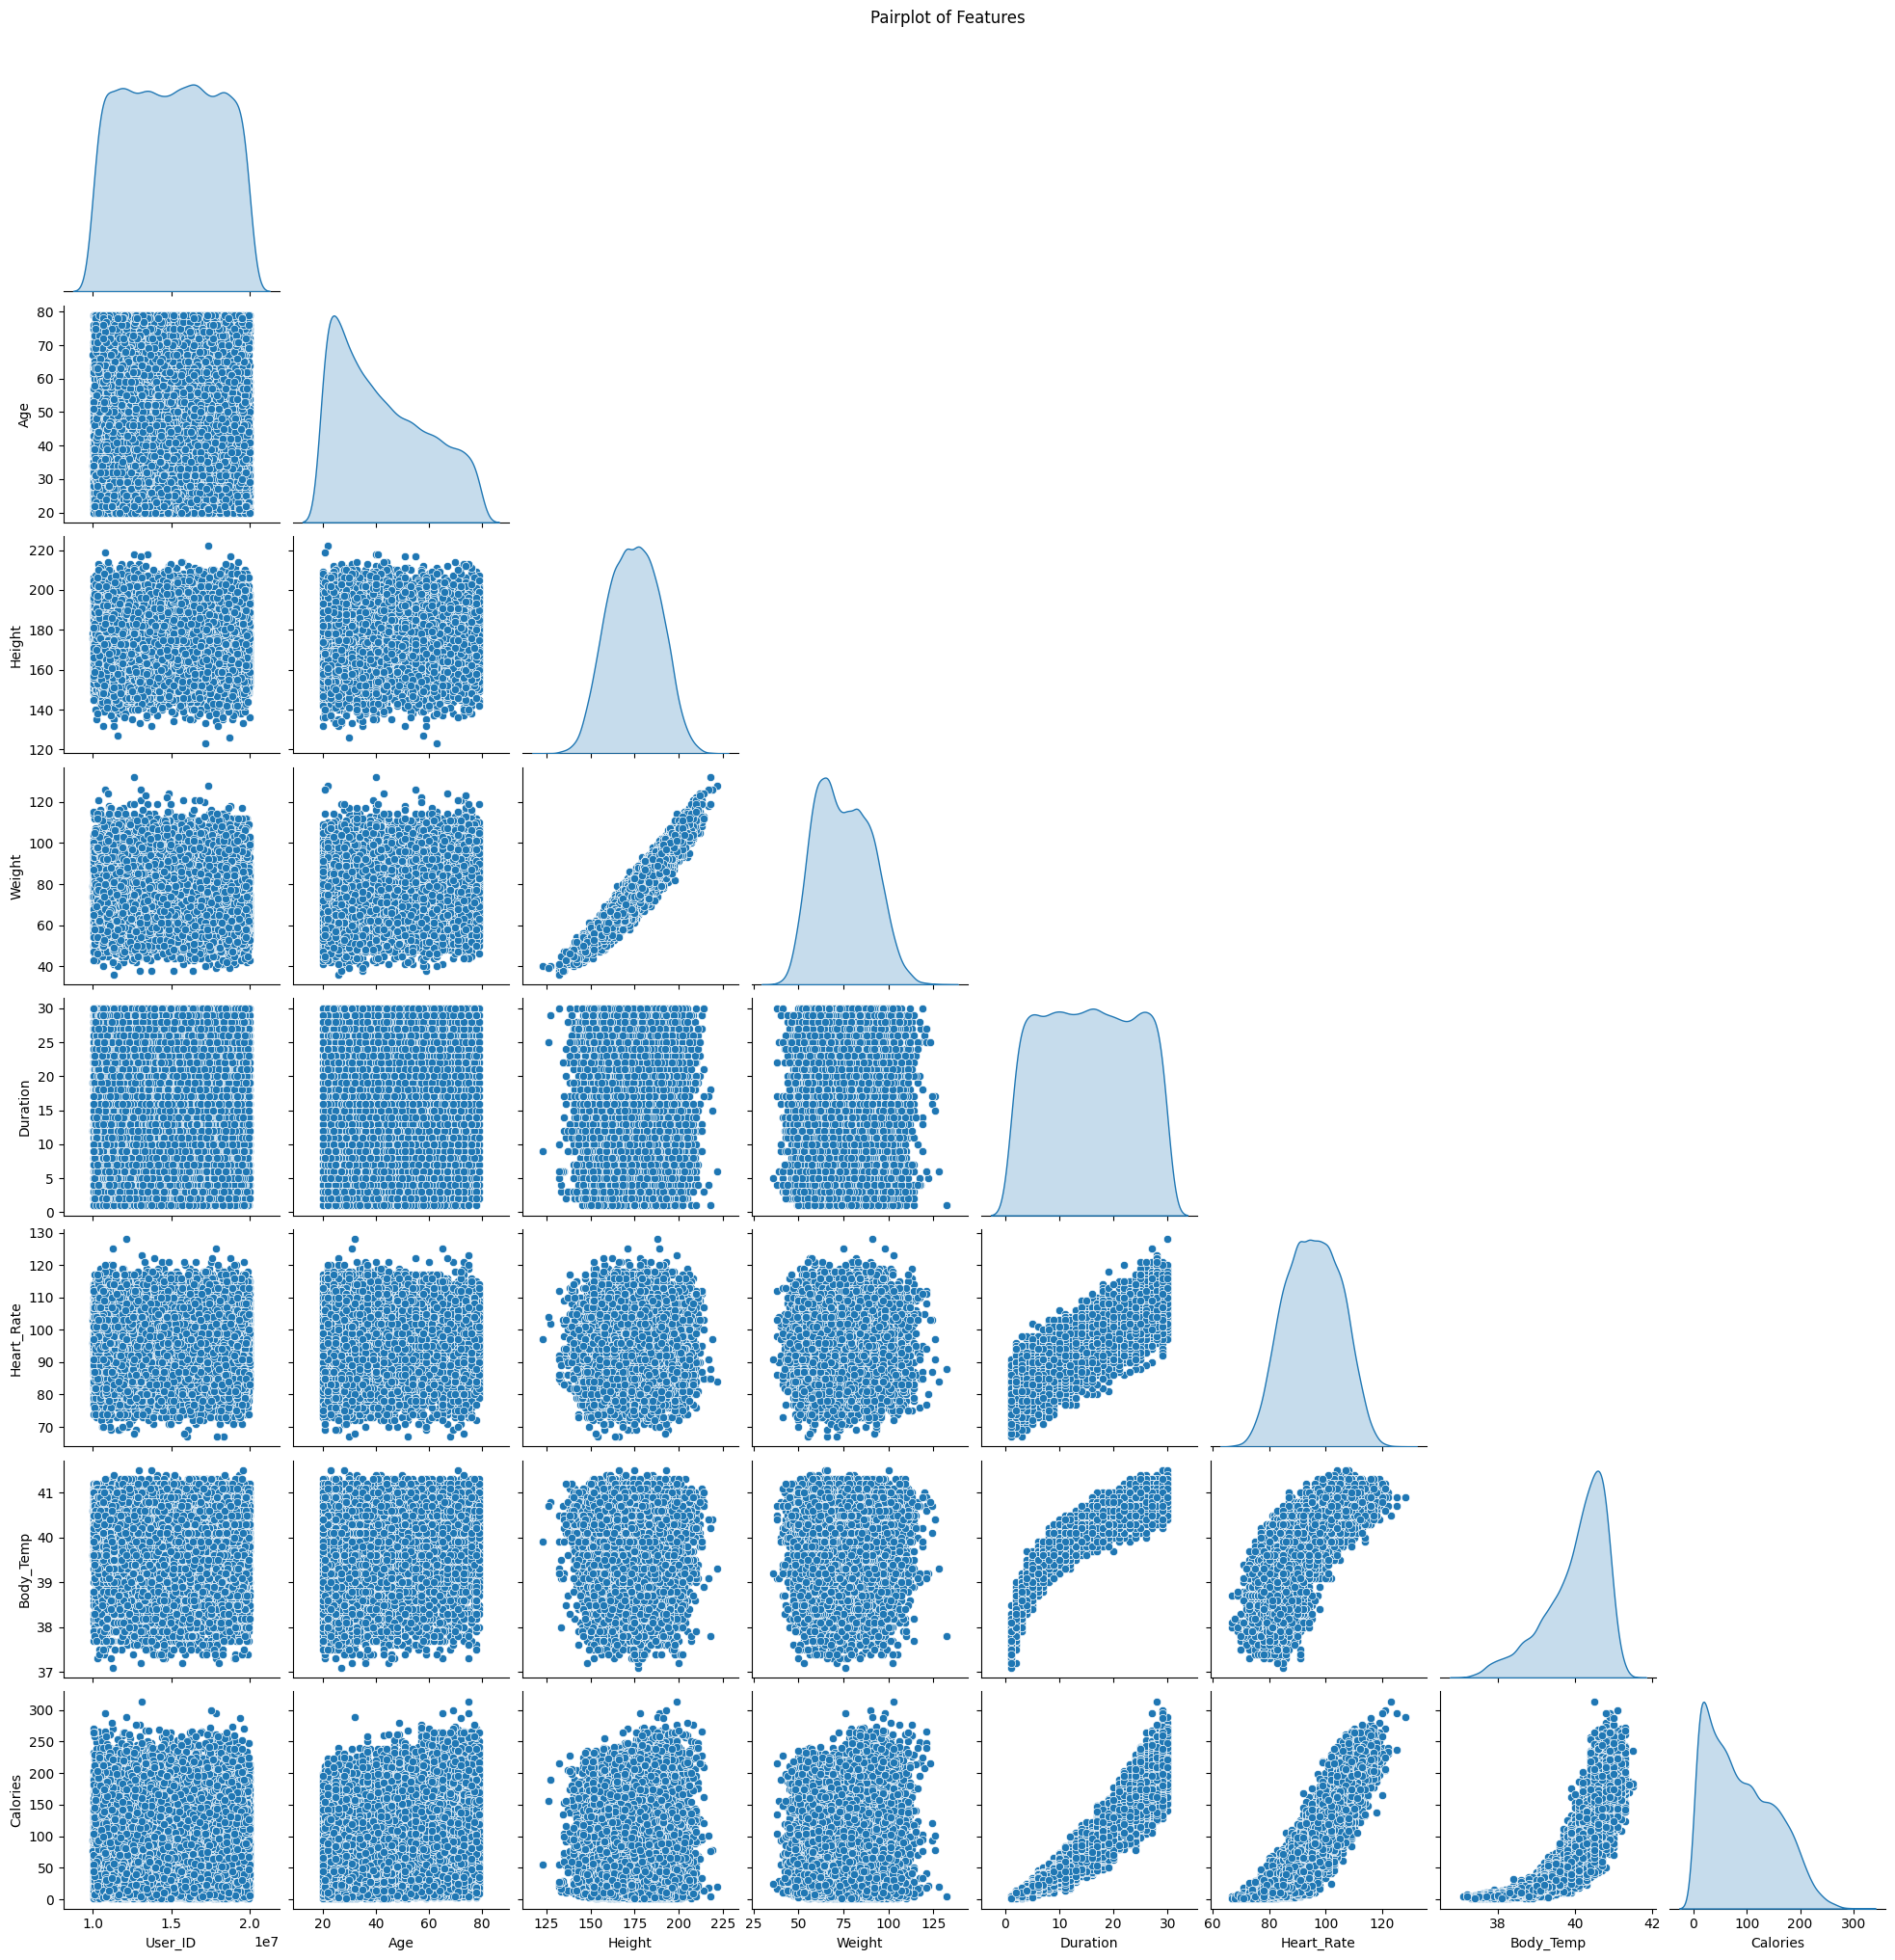

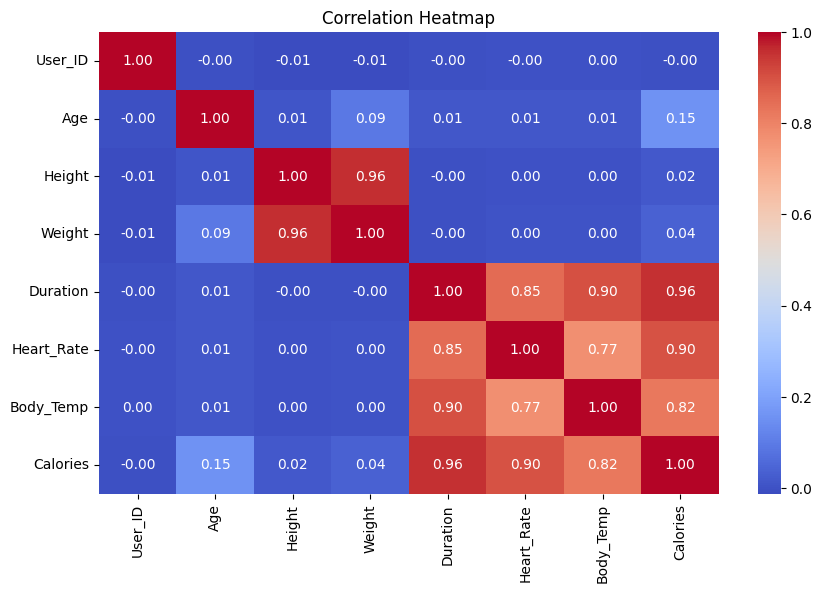

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(data['Calories'], kde=True, color='blue', bins=30)
plt.title('Distribution of Calories')
plt.show()
print("\n")

plt.figure(figsize=(12, 6))
sns.boxplot(data=data, orient='h', palette='Set2')
plt.title('Boxplot of Numerical Features')
plt.show()
print("\n")

sns.pairplot(data, corner=True, diag_kind='kde')
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()
print("\n")

plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
print("\n")

## Encode categorical variables

In [7]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

## Features and target

In [8]:
X = data.drop(['User_ID', 'Calories'], axis=1)  # Drop id and target variable
y = data['Calories']

## Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling features

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Definition

In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'SVR': SVR()
}

## Hyperparameter Grids

In [12]:
grids = {
    'Linear Regression': {},
    'Decision Tree': {'max_depth': [None, 10, 20, 30]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 10]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

## Train and evaluate models

In [13]:
results = {}
best_model = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(model, grids[name], scoring='r2', cv=5, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test_scaled)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    accuracy = r2 * 100  # Accuracy as percentage of R^2 score

    results[name] = {
        'Best Params': grid.best_params_,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2,
        'Accuracy (%)': accuracy
    }


Training Linear Regression...

Training Decision Tree...

Training Random Forest...

Training XGBoost...

Training SVR...


## Results Analysis

In [14]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison: \n", results_df)


Model Comparison: 
                                               Best Params       MAE  \
Linear Regression                                      {}  8.441514   
Decision Tree                           {'max_depth': 20}  3.455889   
Random Forest      {'max_depth': 20, 'n_estimators': 200}  1.682875   
XGBoost             {'max_depth': 6, 'n_estimators': 200}  1.344292   
SVR                            {'C': 10, 'kernel': 'rbf'}  0.570171   

                          MSE      RMSE       R^2 Accuracy (%)  
Linear Regression  131.995746  11.48894  0.967294    96.729372  
Decision Tree       28.750926  5.361989  0.992876    99.287601  
Random Forest        6.944129  2.635172  0.998279    99.827936  
XGBoost              3.836831  1.958783  0.999049     99.90493  
SVR                  1.512196  1.229714  0.999625     99.96253  


## Best Model

In [15]:
best_model_name = results_df['R^2'].idxmax()
print(f"\nBest Model: {best_model_name}")


Best Model: SVR


## Comparison Inferences

In [16]:
print("\nComparison Inferences:")
print(f"The {best_model_name} model has the highest R^2 score and accuracy, indicating it fits the data better than the other models.")
print("Other models like Decision Tree and Linear Regression might be faster but are less accurate.")
print("Random Forest and XGBoost generally provide robust performance for complex datasets.")


Comparison Inferences:
The SVR model has the highest R^2 score and accuracy, indicating it fits the data better than the other models.
Other models like Decision Tree and Linear Regression might be faster but are less accurate.
Random Forest and XGBoost generally provide robust performance for complex datasets.


## Comparision Plots

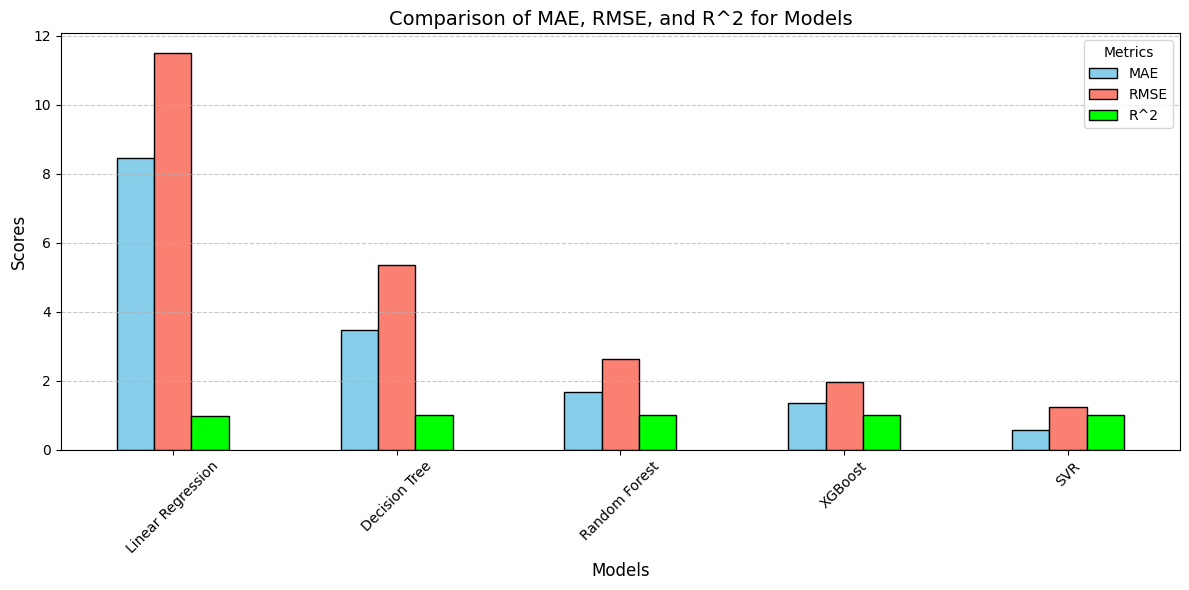

In [17]:
plt.figure(figsize=(12, 6))
results_df[['MAE', 'RMSE', 'R^2']].plot(
    kind='bar',
    ax=plt.gca(),  # Use current axes
    color=['skyblue', 'salmon', 'lime'],
    edgecolor='black'
)
plt.title('Comparison of MAE, RMSE, and R^2 for Models', fontsize=14)
plt.ylabel('Scores', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.xlabel('Models', fontsize=12)
plt.legend(title='Metrics', loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

## Accuracy Comparision

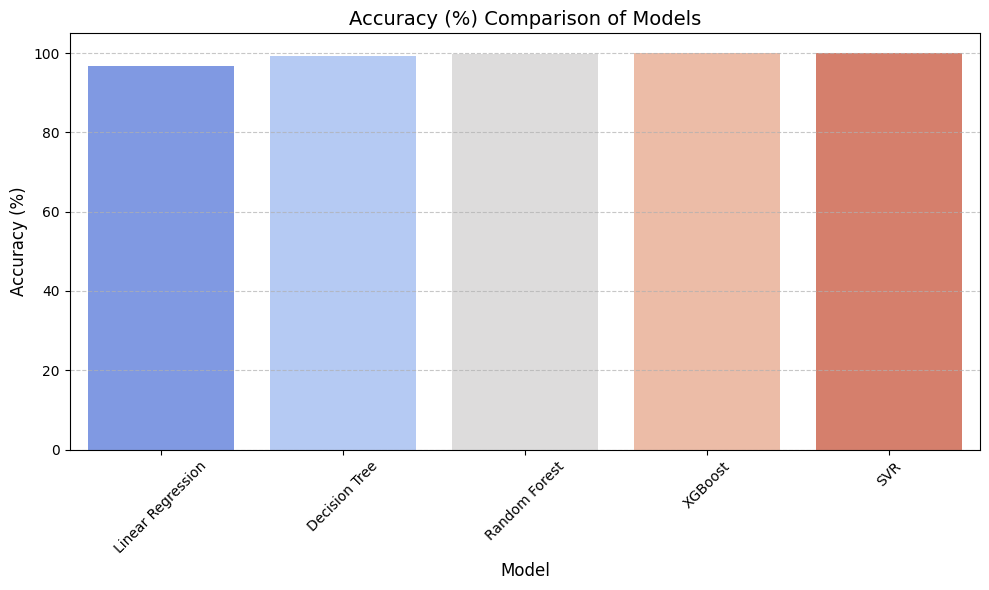

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=results_df.index,
    y=results_df['Accuracy (%)'],
    hue=results_df.index,  # Assign the `x` variable to `hue`
    dodge=False,  # Prevent splitting bars
    palette=sns.color_palette('coolwarm', len(results_df.index))
)
plt.title('Accuracy (%) Comparison of Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend([], [], frameon=False)  # Remove the legend if not needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
import joblib

# Create and train the best model
model = SVR()
model.fit(X_train, y_train)

# Save the best model
joblib.dump(model, "best_model.pkl")

['best_model.pkl']

In [49]:
import gradio as gr
import joblib

# Load the model
model = joblib.load("best_model.pkl")

# Define prediction function
def predict_energy_expenditure(age, gender, height, weight, duration, heart_rate, body_temp):
    try:
        # Encode and cast inputs
        gender_encoded = 0 if gender == "Male" else 1
        input_data = [[
            int(age), int(gender_encoded), float(weight), float(height),
            float(heart_rate), float(duration), float(body_temp)
        ]]
        print("Input data for prediction:", input_data)  # Debugging line
        prediction = model.predict(input_data)
        return f"Estimated Energy Expenditure: {prediction[0]:.2f} calories"
    except Exception as e:
        print("Prediction Error:", str(e))
        return f"Error: {str(e)}"

# Gradio UI
with gr.Blocks() as interface:
    gr.Markdown("# Energy Expenditure Predictor")
    gr.Markdown("Input your details to predict the estimated calories burned.")

    with gr.Row():
        age = gr.Number(label="Age", value=25)
        gender = gr.Radio(["Male", "Female"], label="Gender", value="Male")
        weight = gr.Number(label="Weight (kg)", value=85)
        height = gr.Number(label="Height (cm)", value=175)
        heart_rate = gr.Number(label="Heart Rate (bpm)", value=80)
        duration = gr.Number(label="Exercise Duration (minutes)", value=10)
        body_temp = gr.Number(label="Body Temperature (°C)", value=37)

    predict_button = gr.Button("Predict")
    output = gr.Textbox(label="Prediction")

    predict_button.click(
        fn=predict_energy_expenditure,
        inputs=[age, gender, height, weight, duration, heart_rate, body_temp],
        outputs=output
    )

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://837595d44f6195f193.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
